<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar12/artificial_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 12: Artificial neural networks, MLP, PyTorch
Machine Learning by professor Evgeny Burnaev

In this seminar we will get familiar with artificial neural networks and one of the commonest frameworks to work with them --- PyTorch.
Our humble ultimate goal will be to program and train an MLP to classify MNIST digits.

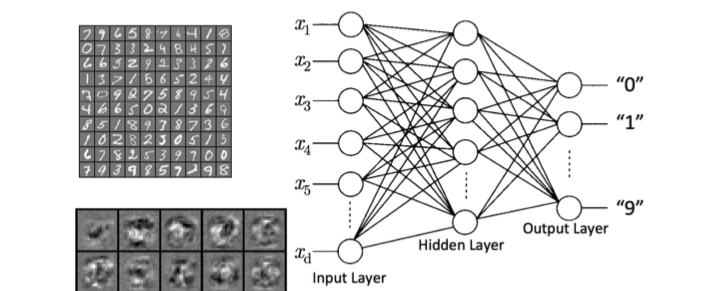

In [ ]:
from IPython.display import clear_output, display
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

## 1. Intro

An artificial neural network --- ANN or just NN, is simply a composition of functions with free 'trainable' parameters, or 'weights'.
In this seminar, we will be talking about NNs that are feedforward, i.e don't have cyclic compositions of the functions,
and we will be talking about them in the context of approximation tasks.

More formally, for any functions $f_i$
$$ f_1(x|w_1),\quad f_2(x, f_1(x)|w_2),\quad f_n(x, f_1(x), \ldots, f_{n-1}(\ldots)|w_n),$$
$F(x) = f_n(\ldots)$ is a feedforward neural network with weights $w_1,\ldots,w_n$,
and we will want it to approximate something, e.g another function.

For instance, let's say that we want to find a linear fit to this:

In [ ]:
points_n = 100
x = np.random.rand(points_n) * 10 - 5
y = x * 3 + 4
y += np.random.randn(points_n) / 2
plt.scatter(x, y)

We can call function $F(x) = ax + b$ a neural network with weights $a$ and $b$, and train this neural network, which means find such values of $a$ and $b$ that $F(x)$ fits the data above.

NNs are trained with backpropagation algorithm, which is basically
1. Calculate the value of the loss function, that represents how far from desired the output of the network is
2. Calculate the derivative of the loss w.r.t to each trainable parameter of the network
3. Somehow update the values of the parameters using these derivatives
4. Repeat steps 1-3 for so many iterations, or until loss is low enough, or something else

### Excercise 1.
Train $F(x) = ax + b$ to fit the data above. Use plain Python or NumPy, not PyTorch.

More formally, we have $x_i,\,y_i,\,i=1,\ldots,n_\mathrm{pts}$
1. Use mean squared error as the loss function $L = \frac{1}{n_\mathrm{pts}}\sum_i (F(x_i) - y_i)^2$
2. Calculate the derivatives of the loss w.r.t to $a$ and $b$
3. Update the weights of the network using gradient descent $a \leftarrow a - \lambda\partial_a L$, $b \leftarrow b - \lambda\partial_b L$, where $\lambda$ is numerical paramer called "learning rate"
4. Repeat steps 1-3 until you are satisfied with the result

In [ ]:
# generate the data again
np.random.seed(0)
points_n = 100
x = np.random.rand(points_n) * 10 - 5
x.sort()  # sort points, merely for correct visualization
y = x * 3 + 4
y += np.random.randn(points_n) / 2

# define the network and initial values of the parameters
a = 1
b = 2

def f(x):
    return x * a + b

# monitoring
fig = plt.figure()

def visualize(fig, x, y, nn_outputs):
    fig.clear()
    plt.title(f'Iteration {iter_i}')
    plt.scatter(x, y, c='tab:blue')
    plt.plot(x, nn_outputs, c='tab:orange')
    clear_output(wait=True)
    display(fig)

# train
learning_rate = 1e-3

for iter_i in range(1):
    nn_outputs = f(x)
    
    # calculate the derivatives
    # Your code here
    
    # update the parameters
    # Your code here

    visualize(fig, x, y, nn_outputs)
plt.close()

### Excercise 2.
Now try to fit this

In [ ]:
np.random.seed(0)
points_n = 100
x = np.random.rand(points_n) * np.pi*3 - np.pi*1.5
x.sort()
y = np.sin(x)
y += np.random.randn(points_n) / 10
plt.scatter(x, y)

with a bit more complex function $F(x) = f_3(f_2(f_1(x)))$

$$f_1(x) = \mathbf{a}_1\,x + \mathbf{b}_1,\quad \mathbf{a}_1,\,\mathbf{b}_1\in\mathbb{R}^{80}, \\
f_2(\mathbf{x})_i = \max(0, x_i),\quad i = 1, \ldots, 80, \\
f_3(\mathbf{x}) = \mathbf{a}_2\cdot\mathbf{x} + b_2,\quad \mathbf{a}_2\in\mathbb{R}^{80},\,b_2\in\mathbb{R}.
$$

The training algorithm is the same, the only basic difference is calculation of derivatives.

In [ ]:
# define the network and initial values of the parameters
a1 = np.random.rand(80)
b1 = np.random.rand(80)
a2 = np.random.rand(80)
b2 = 1

def f(x):
    f1_out = x[..., None] * a1 + b1  # [points_n, 80]
    f2_out = np.maximum(f1_out, 0)
    f3_out = np.matmul(f2_out, a2) + b2
    return f3_out

# train
learning_rate = 1e-3
fig = plt.figure()

for iter_i in range(1):
    nn_outputs = f(x)
    
    # calculate the derivatives
    # Your code here
    
    # update the parameters
    # Your code here

    if iter_i % 100 == 0:
        visualize(fig, x, y, nn_outputs)
plt.close()

Not that easy, right?

The key here is to use chain rule for calculation of derivatives, or "gradients" since now the parameters are multidimensional
$$\frac{\partial L}{\partial \mathbf{a}_1} = \sum_i \frac{\partial L}{\partial F(x_i)} \frac{\partial F(x_i)}{\partial \mathbf{a}_1},\quad
\frac{\partial F(x_i)}{\partial \mathbf{a}_1} = \frac{\partial F(x_i)}{\partial f_3(x_i)}\frac{\partial f_3(x_i)}{\partial f_2(x_i)}\frac{\partial f_2(x_i)}{\partial f_1(x_i)}\frac{\partial f_1(x_i)}{\partial \mathbf{a}_1},\quad \text{etc},$$
where
$$L = \frac{1}{n_\mathrm{pts}}\sum_i (F(x_i) - y_i)^2,\\
F(x) = f_3(f_2(f_1(x))).$$

The neural networks used for real-world tasks are composed of many more functions, and manually programming this each time would be impractical.
Deep learning framewors like PyTorch provide a lot of preprogrammed functionality like this.

Let's quickly look at the overview of the solution of Exercise 2 with PyTorch and then discuss the details.

<font color='gray'>note for the seminarist: copy the code above and rewrite in pytorch inplace</font>

In [ ]:
# define the network and initial values of the parameters
a1 = torch.rand(80, requires_grad=True)
b1 = torch.rand(80, requires_grad=True)
a2 = torch.rand(80, requires_grad=True)
b2 = torch.rand(1, requires_grad=True)

def f(x):
    f1_out = x[..., None] * a1 + b1  # [points_n, 80]
    f2_out = torch.max(f1_out, torch.tensor([0.]))
    f3_out = torch.matmul(f2_out, a2) + b2
    return f3_out

# optimizer
optimizer = torch.optim.SGD([a1, a2, b1, b2], lr=1e-3)

# loss
loss_function = torch.nn.MSELoss()

# convert data
x = torch.as_tensor(x).type(torch.float32)
y = torch.as_tensor(y).type(torch.float32)

# train
fig = plt.figure()
for iter_i in range(1):
    nn_outputs = f(x)
    
    # calculate the derivatives
    loss = loss_function(nn_outputs, y)
    
    # update the parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_i % 100 == 0:
        visualize(fig, x, y, nn_outputs.detach())
plt.close()

### Plan of the seminar
1. Intro to the seminar
2. Intro to PyTorch
3. Automatic differentiation in PyTorch
4. PyTorch Modules
5. Batching
6. Putting everything together
7. Classifying MNIST with PyTorch

## 2. Intro to PyTorch

PyTorch is mostly like NumPy.

In [ ]:
# in numpy
a = np.random.rand(100)
b = np.empty(100)

np.maximum(a, np.array([0.]))
np.matmul(a, b)

np.asarray([1,2,3]).astype(np.float32)

# in pytorch
a = torch.rand(100)
b = torch.empty(100)

torch.max(a, torch.tensor([0.]))
torch.matmul(a, b)

torch.as_tensor([1,2,3]).type(torch.float32)

Etc.
It is useful to look through the complete list of what there is \[[1](https://pytorch.org/docs/stable/torch.html#math-operations), [2](https://pytorch.org/docs/stable/nn.functional.html)\].
For this course generally this is not necessary, but if you're going to use PyTorch for your research or the course project, there are plenty of convenient functions useful to be aware of.

## 3. Automatic differentiation in PyTorch

PyTorch can automatically calculate derivatives of predefined functions and their compositions.
To indicate that we want to calculate derivative of something w.r.t some tensor, we need to set the `requires_grad` flag of this tensor to True.

In [ ]:
x = torch.tensor([1.])
x.requires_grad_()
y = torch.sin(x)

To calculate $\partial_x y(x)$ we need to call `y.backward()` (notice, not `y.backward(x)`). The value of the derivative is then stored in `x.grad`.

In [ ]:
y.backward()
torch.allclose(x.grad, torch.cos(x))

Same for composition of functions.

In [ ]:
x = torch.tensor([2.])
x.requires_grad_()
y = x
y = torch.log(torch.exp(torch.log(torch.exp(x))))
y.backward()
x.grad

Same for multivariate functions.

In [ ]:
x = torch.ones(10)
x.requires_grad_()
coefs = torch.arange(len(x), dtype=x.dtype)
y = torch.sum(x * coefs)
y.backward()

torch.allclose(x.grad, coefs)

If a tensor already has `grad` attribute, e.g from the previous call to `backward`, subsequent calls will add to the value of this attribute.
So, if you, e.g, `backward()` in a loop, you need to explicitely set `grad` to zero each time.

In [ ]:
print('Accumulated grad')
x = torch.tensor([1.])
x.requires_grad_()
for i in 1,1:
    y = x * 2
    y.backward()
    print(x.grad)
    
print('Not accumulated grad')
x = torch.tensor([1.])
x.requires_grad_()
for i in 1,1:
    y = x * 2
    y.backward()
    print(x.grad)
    x.grad.zero_()

PyTorch tensors that don't require grad are transparently converted to numpy arrays.
To convert a tensor that requires grad, we need to call its `detach` method.

In [ ]:
x = torch.ones([10], requires_grad=True)
# plt.plot(x)  # won't work
plt.plot(x.detach())

Let's look at how we used it above, in our train loop.

In [ ]:
if False:
    a1 = torch.rand(80, requires_grad=True)  # indicate that
    b1 = torch.rand(80, requires_grad=True)  # we need
    a2 = torch.rand(80, requires_grad=True)  # gradients
    b2 = torch.rand(1, requires_grad=True)   # w.r.t to this

    def f(x):
        f1_out = x[..., None] * a1 + b1                 # if we need grad
        f2_out = torch.max(f1_out, torch.tensor([0.]))  # w.r.t a1 then
        f3_out = torch.matmul(f2_out, a2) + b2          # w.r.t f1_out as well
        return f3_out

    optimizer = torch.optim.SGD([a1, a2, b1, b2], lr=1e-3)

    loss_function = torch.nn.MSELoss()

    x = torch.as_tensor(x).type(torch.float32)
    y = torch.as_tensor(y).type(torch.float32)

    for iter_i in range(1):
        nn_outputs = f(x)

        loss = loss_function(nn_outputs, y)

        optimizer.zero_grad()
        loss.backward()        # differentiate this
        optimizer.step()

        if iter_i % 100 == 0:
            visualize(fig, x, y, nn_outputs.detach())  # detach for conversion to numpy array

## 4. PyTorch Modules

PyTorch offers a [variety of modules](https://pytorch.org/docs/stable/nn.html) representing different functions with already built-in trainable parameters.
We can replace our manually programmed $f_1$, $f_2$ and $f_3$ with predefined modules, that are called [Linear](https://pytorch.org/docs/stable/nn.html#linear) and [ReLU](https://pytorch.org/docs/stable/nn.html#relu), i.e replace this

In [ ]:
a1 = torch.rand(80, requires_grad=True)
b1 = torch.rand(80, requires_grad=True)
a2 = torch.rand(80, requires_grad=True)
b2 = torch.rand(1, requires_grad=True)

def f(x):
    f1_out = x[..., None] * a1 + b1
    f2_out = torch.max(f1_out, torch.tensor([0.]))
    f3_out = torch.matmul(f2_out, a2) + b2
    return f3_out

optimizer = torch.optim.SGD([a1, a2, b1, b2], lr=1e-3)

with this

In [ ]:
def f(x):
    return f3(f2(f1(x)))

f1 = torch.nn.Linear(1, 80, bias=True)  # acts from R^1 to R^80
f2 = torch.nn.ReLU()
f3 = torch.nn.Linear(80, 1, bias=True)  # acts from R^80 to R^1

optimizer = torch.optim.SGD([*f1.parameters(), *f3.parameters()], lr=1e-3)

Another convenient way of stacking the modules is with [Sequential](https://pytorch.org/docs/stable/nn.html#sequential)

In [ ]:
f = torch.nn.Sequential(
    torch.nn.Linear(1, 80, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(80, 1, bias=True)
)

optimizer = torch.optim.SGD(f.parameters(), lr=1e-3)

## 5. Batching

The inteface of PyTorch modules allows for some batch dimensions in the input data, along which the module acts independently and in parallel.
For instance, `Linear` and `ReLU` allow for any number of batch dimensions.

In [ ]:
f1 = torch.nn.Linear(1, 80, bias=True)

x = torch.empty(size=[1])
print('Shape of x:', x.shape)
print('Shape of output:', f1(x).shape)

x = torch.empty(size=[2, 3, 4, 1])
batch_output = f1(x)
print('Shape of x:', x.shape)
print('Shape of output:', batch_output.shape)

for i in range(2):
    for j in range(3):
        for k in range(4):
            assert torch.allclose(
                f1(x[i, j, k]),
                batch_output[i, j, k]
            )

In our example with sine samples, the size `points_n` corresponds to the batch dimension, since we treat each point independenlty.

In [ ]:
# generate data
torch.manual_seed(0)
points_n = 100
x = torch.rand(points_n, dtype=torch.float32) * np.pi*3 - np.pi*1.5
x = x.sort()[0]
y = torch.sin(x)
y += torch.randn(points_n) / 10

x = x[..., None]  # add data dimension
y = y[..., None]
print(x.shape)

plt.scatter(x, y)

## 6. Putting everything together

Before going further, let's put together our training code.

In [ ]:
hidden_dim_size = 80
net = torch.nn.Sequential(
    torch.nn.Linear(1, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, 1, bias=True)
)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()
fig = plt.figure()

for iter_i in range(1):
    nn_outputs = net(x)
    loss = loss_function(nn_outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if iter_i % 100 == 0:
        visualize(fig, x, y, nn_outputs.detach())
plt.close()

## 7. Classifying MNIST with PyTorch

MNIST is a dataset of images with handwritten digits.
Each image is labeled with the corresponding number.
We'll play around with the version which has ~2k 8x8 images.

In [ ]:
images, targets = load_digits(return_X_y=True)

grid = np.pad(images[:20].reshape(20, 8, 8), [[0, 0], [3, 3], [3, 3]]).reshape(2, 10, 14, 14).swapaxes(1, 2).reshape(28, -1)
plt.figure(figsize=(10, 2))
plt.imshow(grid, cmap='gray_r')
targets[:20].reshape(2, 10)

Let's prepare the data for further work.

In [ ]:
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, random_state=0)
images_train = torch.from_numpy(images_train.astype(np.float32))
images_test = torch.from_numpy(images_test.astype(np.float32))
targets_train = torch.from_numpy(targets_train)
targets_test = torch.from_numpy(targets_test)

What we'll do, we'll unroll each image into an array of 64 values and will train our $F(x)$ from above to predict an array of 10 values, each corresponding to probability of the image depicting the respective digit.

More formally, $F(\mathbf{x}) = f_3(f_2(f_1(\mathbf{x}))),\quad \mathbf{x}\in\mathbb{R}^{64}$,
$$f_1(\mathbf{x}) = A_1\cdot \mathbf{x} + \mathbf{b}_1,\quad A_1\in\mathbb{R}^{80\times 64},\quad \mathbf{b}_1\in\mathbb{R}^{80}, \\
f_2(\mathbf{x})_i = \max(0, x_i),\quad i = 1, \ldots, 80, \\
f_3(\mathbf{x}) = A_2\cdot\mathbf{x} + \mathbf{b}_2,\quad A_2\in\mathbb{R}^{10\times 80},\,\mathbf{b}_2\in\mathbb{R}^{10}.
$$

In [ ]:
hidden_dim_size = 80
input_size = 8 * 8
number_of_classes = 10
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

Since we want to get probablities $p_i$ of different digits out of the network,
we will pass the output of the network to softmax function
$$\mathrm{SoftMax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
to enforce the properties of probabilities,
i.e $0 \le p_i \le 1$, $\sum_i p_i = 1$.

In [ ]:
net_outputs = net(images_train[0])
print(torch.all((0 <= net_outputs) & (net_outputs <= 1)))
print(torch.allclose(net_outputs.sum(), torch.ones(1)))

In [ ]:
softmax = torch.nn.Softmax(dim=-1)
probabilities = softmax(net_outputs)

print(torch.all((0 <= probabilities) & (probabilities <= 1)))
print(torch.allclose(probabilities.sum(), torch.ones(1)))

We then just take the index of maximal predicted probability

In [ ]:
probabilities.max(dim=-1)[1], targets_train[0]

We will use [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss) loss function, suitable for multi-class classification.
It does conversion to probabilities by itself, so we just pass it the outputs of the network and the label of the image.

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

loss_function(net_outputs[None], targets_train[:1])

### Excercise 3.
Let's put everything together and try to train our network (it is MLP btw).

In [ ]:
# define the network
# Your code here

# use the same optimizer as before
# Your code here

# use the cross entropy loss function
# Your code here

# for monitoring we'll use confusion matrices on the train and test sets
fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=[10, 5])

def visualize():
    ax_train.clear()
    ax_train.set_title(f'Iteration {iter_i}, train')
    ax_train.matshow(confusion_matrix(targets_train, get_predicted_classes(images_train)))
    ax_test.set_title(f'test')
    ax_test.matshow(confusion_matrix(targets_test, get_predicted_classes(images_test)))
    clear_output(wait=True)
    display(fig)
    
def get_predicted_classes(images):
    # Your code here

for iter_i in range(1):
    # Your code here
    if iter_i % 10 == 0:
        visualize()
plt.close()